# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Random Forest, and will then apply a Decision Tree classsifier and random forest on the MNIST hand written digits dataset that we already saw.


## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer
1. When using the Information Gain criterion for the split, the function we want to minimize is the weighted entropy, where entropy is defined by:

    $$
    H(X_m)=-\sum_{k} p_{mk}\log_2(p_{mk})
    $$

    In the case of feature 1 we get (if all of the samples have the same label in a leaf, the entropy is 0):

    $$
    H(X_1, feat.  1) = \frac{3}{4}(-\frac{2}{3}\log \frac{2}{3} - \frac{1}{3}\log \frac{1}{3}) + \frac{1}{4}(0) \approx 0.6887
    $$

    In the case of feature 2 and 3 (same entropy score), we get:

    $$
    H(X_1, feat.  2/3) = \frac{1}{2}(-\frac{1}{2}\log \frac{1}{2} - \frac{1}{2}\log \frac{1}{2}) + \frac{1}{2}(-\frac{1}{2}\log \frac{1}{2} - \frac{1}{2}\log \frac{1}{2}) = 1
    $$

    So we will split according to feature 1 (lowest weighted entropy).

    Now, we consider splitting according to feature 2 or 3:

    $$
    H(X_2, feat.  2) = H(X_2, feat.  3) = \frac{2}{3}(-\frac{1}{2}\log \frac{1}{2} - \frac{1}{2}\log \frac{1}{2}) + \frac{1}{3}(0) = \frac{2}{3}
    $$

    Again the split does not matter, so we can randomly choose between feature 2 and 3.

    This means that our tree has 3 leaf nodes, 2 of which have only 1 sample so the error is 0, but in the 3rd leaf we have 2 samples, one from each class (0 or 1), so regardless of what we assign to that leaf, we will be mistaken on one of them, which means we will have an error of 1/4.


2. If you first split according to feature 2, and then according to feature 3, you get one sample in each of the four leaf nodes, which means 0 training error.

## Implementing Random Forest From Scratch
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes). 

* Compelete the skeleton class below (hint: you should also create a `DecisionTree` class that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(n)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the bostom dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
  



In [1]:
class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, min_leaf):
        np.random.seed(1)
        self.X, self.y, self.n_trees, self.sample_sz, self.min_leaf = X, y, n_trees, sample_sz, min_leaf
        self.sample_count, self.feature_count = X.shape
        self.trees = self._create_trees()
        
    def _create_trees(self):
        trees = []
        for i in range(self.n_trees):
            ib_index = np.random.choice(self.sample_count, size=self.sample_sz, replace=True)
            trees.append(DecisionTree(self.X, self.y, ib_index=ib_index, min_leaf=self.min_leaf))
        return trees

    def predict(self, X):
        return np.mean([tree.predict(X) for tree in self.trees], axis=0)

    def oob_mse(self):
        oob_mse = []
        for i in range(self.sample_count):
            oob_vec = []
            for tree in self.trees:
                if i not in tree.ib_index:
                    oob_vec.append(tree._predict_sample(self.X[i]))
            if oob_vec:
                sample_pred = np.mean(oob_vec)        
                oob_mse.append((sample_pred - self.y[i])**2)
        return np.mean(oob_mse)


In [2]:
class DecisionTree():
    
    def __init__(self, X, y, ib_index, min_leaf):
        self.X, self.y, self.ib_index, self.min_leaf = X, y, ib_index, min_leaf
        self.sample_count, self.feature_count = len(ib_index), X.shape[1]
        self.leaf_value = np.mean(y[ib_index])
        self.score = float('inf')
        self._split()
        
    def _split(self):
        for i in range(self.feature_count):
            self._find_best_split(i)
        if self.score == float('inf'):
            return
        split_col = self.X[self.ib_index, self.feature_index]
        left_index = np.nonzero(split_col <= self.split_value)
        right_index = np.nonzero(split_col > self.split_value)
        self.left_tree = DecisionTree(self.X, self.y, self.ib_index[left_index], self.min_leaf)
        self.right_tree = DecisionTree(self.X, self.y, self.ib_index[right_index], self.min_leaf)
    
    def _find_best_split(self, feature_index):
        X = self.X[self.ib_index, feature_index]
        y = self.y[self.ib_index]
        sorted_X = X[np.argsort(X)]
        sorted_y = y[np.argsort(X)]
        right_count, left_count = self.sample_count, 0
        right_sum, left_sum = sorted_y.sum(), 0.0
        right_sum_sqr, left_sum_sqr = (sorted_y**2).sum(), 0.0
        
        for i in range(self.sample_count-self.min_leaf):
            xi, yi = sorted_X[i], sorted_y[i]
            
            if (xi == sorted_X[i+1]) or (i < self.min_leaf - 1):
                continue
            
            right_count -= 1
            left_count += 1
            right_sum -= yi
            left_sum += yi
            right_sum_sqr -= yi**2
            left_sum_sqr += yi**2
            
            right_var = (right_sum_sqr/right_count) - (right_sum/right_count)**2
            left_var = (left_sum_sqr/left_count) - (left_sum/left_count)**2
            score = right_var * right_count + left_var * left_count
            if score < self.score:
                self.score = score
                self.feature_index = feature_index
                self.split_value = xi
                
    def _predict_sample(self, x):
        if self.score == float('inf'):
            return self.leaf_value
        if x[self.feature_index] <= self.split_value:
            next_tree = self.left_tree
        else:
            next_tree = self.right_tree
        return next_tree._predict_sample(x)
    
    def predict(self, X):
        return np.array([self._predict_sample(x) for x in X])

In [3]:
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
X, y = load_boston(return_X_y=True)

In [5]:
for n in [1,5,10,20,50,100]:
    for sz in [50,100,300,500]:
        for min_leaf in [1,5]:
            forest = TreeEnsemble(X, y, n, sz, min_leaf)
            mse = forest.oob_mse()
            print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))

n_trees:1, sz:50, min_leaf:1 --- oob mse: 68.15687772925764
n_trees:1, sz:50, min_leaf:5 --- oob mse: 78.88582494083514
n_trees:1, sz:100, min_leaf:1 --- oob mse: 47.369565217391305
n_trees:1, sz:100, min_leaf:5 --- oob mse: 44.771466278148395
n_trees:1, sz:300, min_leaf:1 --- oob mse: 29.10410256410257
n_trees:1, sz:300, min_leaf:5 --- oob mse: 29.612187858167278
n_trees:1, sz:500, min_leaf:1 --- oob mse: 28.55426229508196
n_trees:1, sz:500, min_leaf:5 --- oob mse: 26.09212331368137
n_trees:5, sz:50, min_leaf:1 --- oob mse: 27.331570707070703
n_trees:5, sz:50, min_leaf:5 --- oob mse: 42.50607090084376
n_trees:5, sz:100, min_leaf:1 --- oob mse: 23.27887650966184
n_trees:5, sz:100, min_leaf:5 --- oob mse: 30.224977847399888
n_trees:5, sz:300, min_leaf:1 --- oob mse: 16.46714406922043
n_trees:5, sz:300, min_leaf:5 --- oob mse: 23.378075094016584
n_trees:5, sz:500, min_leaf:1 --- oob mse: 16.83203132581271
n_trees:5, sz:500, min_leaf:5 --- oob mse: 21.193335078187836
n_trees:10, sz:50, mi

In [6]:
forest = TreeEnsemble(X, y, 100, 500, 1)
y_hat = forest.predict(X)

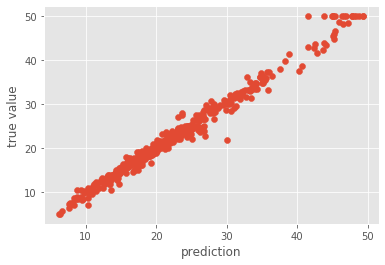

In [7]:
plt.scatter(y_hat, y)
plt.ylabel('true value')
plt.xlabel('prediction');

## Using Decision Tree and Random Forest for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier` and `sklearn.ensemble.RandomForestClassifier`
- Once you are satisfied with the model parameters, plot for each of the models (a single decision tree and random forest) the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

In [8]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [9]:
mnist = datasets.fetch_openml('mnist_784')

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=1/7.0, random_state=0)

## Decision tree

In [11]:
num_feature = np.linspace(100, X_train.shape[1], 5).astype(int)

for criterion in ['gini', 'entropy']:
    for max_depth in [5, 15, 25, 35, 45]:
        for max_features in num_feature:
            DT_model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features)
            scores = cross_val_score(DT_model,X_train[:5000], y_train[:5000])
            print("citerion:{0}, max_depth:{1}, max_features:{2} --- score: {3:.4f}".format(criterion, max_depth, max_features, scores.mean()))

citerion:gini, max_depth:5, max_features:100 --- score: 0.5866
citerion:gini, max_depth:5, max_features:271 --- score: 0.6474
citerion:gini, max_depth:5, max_features:442 --- score: 0.6624
citerion:gini, max_depth:5, max_features:613 --- score: 0.6692
citerion:gini, max_depth:5, max_features:784 --- score: 0.6752
citerion:gini, max_depth:15, max_features:100 --- score: 0.7386
citerion:gini, max_depth:15, max_features:271 --- score: 0.7488
citerion:gini, max_depth:15, max_features:442 --- score: 0.7644
citerion:gini, max_depth:15, max_features:613 --- score: 0.7616
citerion:gini, max_depth:15, max_features:784 --- score: 0.7606
citerion:gini, max_depth:25, max_features:100 --- score: 0.7310
citerion:gini, max_depth:25, max_features:271 --- score: 0.7550
citerion:gini, max_depth:25, max_features:442 --- score: 0.7482
citerion:gini, max_depth:25, max_features:613 --- score: 0.7536
citerion:gini, max_depth:25, max_features:784 --- score: 0.7616
citerion:gini, max_depth:35, max_features:100

In [12]:
DT_model = DecisionTreeClassifier(criterion='entropy', max_depth=35, max_features=613)
DT_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=35, max_features=613, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
print('Mean accuracy: {0:.4f}'.format(DT_model.score(X_test, y_test)))

Mean accuracy: 0.8819


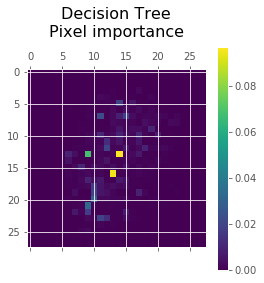

In [14]:
importance = DT_model.feature_importances_
plt.matshow(importance.reshape(28,28));
plt.colorbar()
plt.title('Decision Tree\nPixel importance\n', fontsize=16);

In [15]:
y_pred = DT_model.predict(X_test)
correct = DT_model.predict_proba(X_test[y_pred == y_test]).max(axis=1)
incorrect = DT_model.predict_proba(X_test[y_pred != y_test]).max(axis=1)

print('Class probabilities of correctly classified test samples: {0:.4f}, and misclassified test samples: {1:.4f}'.format(correct.mean(), incorrect.mean()))

Class probabilities of correctly classified test samples: 1.0000, and misclassified test samples: 1.0000


## Random forest

In [16]:
num_feature = np.linspace(100, X_train.shape[1], 5).astype(int)

for criterion in ['gini', 'entropy']:
    for num_trees in [100, 200, 300]:
        for max_depth in [10, 20, 30]:
            for max_features in num_feature:
                RF_model = RandomForestClassifier(n_estimators=num_trees, criterion=criterion, max_depth=max_depth, max_features=max_features)
                scores = cross_val_score(DT_model,X_train[:2000], y_train[:2000])
                print("n_estimators:{4}, citerion:{0}, max_depth:{1}, max_features:{2} --- score: {3:.4f}".format(criterion, max_depth, max_features, scores.mean(), num_trees))

n_estimators:100, citerion:gini, max_depth:10, max_features:100 --- score: 0.7000
n_estimators:100, citerion:gini, max_depth:10, max_features:271 --- score: 0.6840
n_estimators:100, citerion:gini, max_depth:10, max_features:442 --- score: 0.6915
n_estimators:100, citerion:gini, max_depth:10, max_features:613 --- score: 0.6960
n_estimators:100, citerion:gini, max_depth:10, max_features:784 --- score: 0.7125
n_estimators:100, citerion:gini, max_depth:20, max_features:100 --- score: 0.7190
n_estimators:100, citerion:gini, max_depth:20, max_features:271 --- score: 0.6970
n_estimators:100, citerion:gini, max_depth:20, max_features:442 --- score: 0.6920
n_estimators:100, citerion:gini, max_depth:20, max_features:613 --- score: 0.7025
n_estimators:100, citerion:gini, max_depth:20, max_features:784 --- score: 0.6895
n_estimators:100, citerion:gini, max_depth:30, max_features:100 --- score: 0.7065
n_estimators:100, citerion:gini, max_depth:30, max_features:271 --- score: 0.6945
n_estimators:100

In [18]:
RF_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=20, max_features=100)
RF_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
print('Mean accuracy: {0:.4f}'.format(RF_model.score(X_test, y_test)))

Mean accuracy: 0.9681


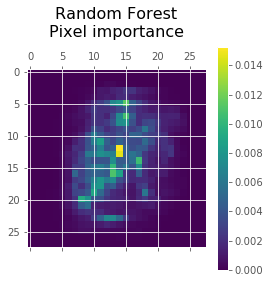

In [22]:
importance = RF_model.feature_importances_
plt.matshow(importance.reshape(28,28));
plt.colorbar()
plt.title('Random Forest\nPixel importance\n', fontsize=16);

In [21]:
y_pred = RF_model.predict(X_test)
correct = RF_model.predict_proba(X_test[y_pred == y_test]).max(axis=1)
incorrect = RF_model.predict_proba(X_test[y_pred != y_test]).max(axis=1)

print('Class probabilities of correctly classified test samples: {0:.4f}, and misclassified test samples: {1:.4f}'.format(correct.mean(), incorrect.mean()))

Class probabilities of correctly classified test samples: 0.8615, and misclassified test samples: 0.4516


There are quite a few model parameters to optimize, but we decided on what we think are the major ones: criterion, max depth, max features, and for Random forest also number of estimators. The way to optimise is by grid searching and cross validating at each point. Since this can be very time consuming, we decreased the number of samples to 5000 in the decision tree and 2000 in the random forest.

In the decision tree it looks like you need a minimal depth to achieve a relatively similar MSE for both criterions and it really isn't too sensitive to the number of features (even 1/8 of the feature seems to perform quite well).
For the forest, it again seems quite insensitive to the parameters, if you choose them to be in a "working range" of the model (avoiding too few features, or too shallow of depth etc.).

The accuracy of the random forest is clearly superior, not surprising since random forest is a generalization of the decision tree method.

In the pixel importance images we can see a similar pattern, although the random forest one looks more detailed. The pixels near the center seem to be more important.

Regarding class probabilities for correctly classified and misclassified test samples, we can see that while the random forest is "not sure" about the misclassified samples (only about 45% probability), the decision tree is very confident in his misclassifications at 100%. Again, an indication of why the random forest is much better at this classification task, as it avoids overfitting the data better.

## References
- https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/